In [1]:
import numpy as np
import argparse
import time
import os
import collections
import json
import queue
import time

from utils.data_utils import load_dataset_numpy

import scipy.spatial.distance

from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import maximum_flow
from utils.flow import _make_edge_pointers

from cvxopt import solvers, matrix, spdiag, log, mul, sparse, spmatrix

In [2]:
def minll(G,h,p):
    m,v_in=G.size
    def F(x=None,z=None):
        if x is None:
            return 0, matrix(1.0,(v,1))
        if min(x)<=0.0:
            return None
        f = -sum(mul(p,log(x)))
        Df = mul(p.T,-(x**-1).T)
        if z is None:
            return f,Df
        # Fix the Hessian
        H = spdiag(z[0]*mul(p,x**-2))
        return f,Df,H
    return solvers.cp(F,G=G,h=h)

In [3]:
def find_remaining_cap_edges(edge_ptr,capacities,heads,tails, source, sink):
    ITYPE = np.int32
    n_verts = edge_ptr.shape[0] - 1
    n_edges = capacities.shape[0]
    ITYPE_MAX = np.iinfo(ITYPE).max

    # Our result array will keep track of the flow along each edge
    flow = np.zeros(n_edges, dtype=ITYPE)

    # Create a circular queue for breadth-first search. Elements are
    # popped dequeued at index start and queued at index end.
    q = np.empty(n_verts, dtype=ITYPE)

    # Create an array indexing predecessor edges
    pred_edge = np.empty(n_verts, dtype=ITYPE)

    # While augmenting paths from source to sink exist
    for k in range(n_verts):
        pred_edge[k] = -1
    path_edges = []
    # Reset queue to consist only of source
    q[0] = source
    start = 0
    end = 1
    # While we have not found a path, and queue is not empty
    path_found = False
    while start != end and not path_found:
        # Pop queue
        cur = q[start]
        start += 1
        if start == n_verts:
            start = 0
        # Loop over all edges from the current vertex
        for e in range(edge_ptr[cur], edge_ptr[cur + 1]):
            t = heads[e]
            if pred_edge[t] == -1 and t != source and\
                    capacities[e] > flow[e]:
                pred_edge[t] = e
                path_edges.append((cur,t))
                if t == sink:
                    path_found = True
                    break
                # Push to queue
                q[end] = t
                end += 1
                if end == n_verts:
                    end = 0
    return path_edges


In [4]:
def create_graph_rep(edge_matrix,n_1,n_2,weights):
    graph_rep = []
    for i in range(n_1+n_2+2):
        graph_rep.append([])
        if i==0:
            #source
            for j in range(n_1+n_2+2):
                if j==0:
                    graph_rep[i].append(0)
                elif 1<=j<=n_1:
                    graph_rep[i].append(weights[j-1])
                elif n_1<j<=n_1+n_2+1:
                    graph_rep[i].append(0)
        elif 1<=i<=n_1:
            # LHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1:
                    graph_rep[i].append(0)
                elif n_1<j<=n_1+n_2:
                    if edge_matrix[i-1,j-n_1-1]:
                        graph_rep[i].append(1)
                    else:
                        graph_rep[i].append(0)
                elif n_1+n_2<j:
                    graph_rep[i].append(0)
        elif n_1<i<=n_1+n_2:
            #RHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1+n_2:
                    graph_rep[i].append(0)
                elif j>n_1+n_2:
                    graph_rep[i].append(weights[i-1])
        elif i==n_1+n_2+1:
            #Sink
            for j in range(n_1+n_2+2):
                graph_rep[i].append(0)

    graph_rep_array=np.array(graph_rep)

    return graph_rep_array

In [5]:
def set_classifier_prob_full_flow(top_level_vertices,w_1_curr,w_2_curr):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            classifier_probs[item-1,0]=w_1_curr/(w_1_curr+w_2_curr)
            classifier_probs[item-1,1]=w_2_curr/(w_1_curr+w_2_curr)

In [6]:
def set_classifier_prob_no_flow(top_level_vertices):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            if item<=n_1:
                classifier_probs[item-1,0]=1
                classifier_probs[item-1,1]=0
            elif item>n_1:
                classifier_probs[item-1,0]=0
                classifier_probs[item-1,1]=1

In [7]:
def graph_rescale(graph_rep_curr,top_level_indices,weights):
    class_1_vertices=top_level_indices[( top_level_indices> 0) & (top_level_indices<=n_1)]
    class_1_weights=weights[class_1_vertices-1]
    w_1_curr=np.sum(class_1_weights)
    class_2_vertices=top_level_indices[ (top_level_indices>n_1) & (top_level_indices<=n_1+n_2)]
    class_2_weights=weights[class_2_vertices-1]
    w_2_curr=np.sum(class_2_weights)
    n_1_curr=len(class_1_vertices)
    n_2_curr=len(class_2_vertices)
    #n_1_curr=len(np.where(top_level_indices<=n_1)[0])-1
    #n_2_curr=len(np.where(top_level_indices>n_1)[0])-1
    # source rescale
    # print(graph_rep_curr[0])
    #graph_rep_curr[0,:]=graph_rep_curr[0,:]/n_2
    graph_rep_curr[0,:]= (graph_rep_curr[0,:]*w_2_curr)
    # print(graph_rep_curr[0])
    # bipartite graph edge scale
    #graph_rep_curr[1:n_1_curr+1,:]=graph_rep_curr[1:n_1_curr+1,:]/(n_1*n_2)
    graph_rep_curr[1:n_1_curr+1,:]=(graph_rep_curr[1:n_1_curr+1,:]*(w_1_curr*w_2_curr))
    # sink edges rescale
    #graph_rep_curr[n_1_curr+1:,:]=graph_rep_curr[n_1_curr+1:,:]/n_1
    graph_rep_curr[n_1_curr+1:,:]=(graph_rep_curr[n_1_curr+1:,:]*w_1_curr)
    #print(f"The graph_rep_curr is {graph_rep_curr}, w_1_curr is : {w_1_curr},w_2_curr is : {w_2_curr}")
    return graph_rep_curr,w_1_curr,w_2_curr

In [8]:
def find_flow_and_split(top_level_indices,weights):
    top_level_indices_1=None
    top_level_indices_2=None
    #Create subgraph from index array provided
    graph_rep_curr = graph_rep_array[top_level_indices]
    graph_rep_curr = graph_rep_curr[:,top_level_indices]
    graph_rep_curr,w_1_curr,w_2_curr = graph_rescale(graph_rep_curr,top_level_indices,weights)
    print(f"The weight1 is : {w_1_curr} , the weight2 is:{w_2_curr}")
    graph_curr=csr_matrix(graph_rep_curr)
    flow_curr = maximum_flow(graph_curr,0,len(top_level_indices)-1)
    print(f"The flow value is:{flow_curr.flow_value}")
    # Checking if full flow occurred, so no need to split
    if flow_curr.flow_value==0:
        set_classifier_prob_no_flow(top_level_indices)
        return top_level_indices_1,top_level_indices_2, flow_curr
    elif flow_curr.flow_value==w_1_curr*w_2_curr:
        if (w_1_curr*w_2_curr)>=2**32:
            print("There is overflow")
        set_classifier_prob_full_flow(top_level_indices,w_1_curr,w_2_curr)
        return top_level_indices_1,top_level_indices_2, flow_curr
    # Finding remaining capacity edges
    remainder_array = graph_curr-flow_curr.residual
    #print(f"The remainder array is :{ remainder_array}")

    rev_edge_ptr, tails = _make_edge_pointers(remainder_array)
    #print(f"The rev_edge and tails are : {rev_edge_ptr} and {tails}")
    edge_ptr=remainder_array.indptr
    capacities=remainder_array.data
    heads=remainder_array.indices

    edge_list_curr = find_remaining_cap_edges(edge_ptr,capacities,heads,tails,0,len(top_level_indices)-1)

    #print(f"The edge_list_curr is {edge_list_curr}")
    gz_idx = []
    for item in edge_list_curr:
        gz_idx.append(item[0])
        gz_idx.append(item[1])
    #print(f"The gz_idx is {gz_idx}")
    if len(gz_idx)>0:
        gz_idx=np.array(gz_idx)
        gz_idx_unique=np.unique(gz_idx)
        top_level_gz_idx=top_level_indices[gz_idx_unique]
        top_level_gz_idx=np.insert(top_level_gz_idx,len(top_level_gz_idx),sink_idx)
        top_level_indices_1=top_level_gz_idx
    else:
        top_level_gz_idx=np.array([0,sink_idx])
    # Indices without flow
    top_level_z_idx=np.setdiff1d(top_level_indices,top_level_gz_idx)
    if len(top_level_z_idx)>0:
        # Add source and sink back to zero flow idx array
        top_level_z_idx=np.insert(top_level_z_idx,0,0)
        top_level_z_idx=np.insert(top_level_z_idx,len(top_level_z_idx),sink_idx)
        top_level_indices_2=top_level_z_idx
    #print(top_level_indices_1, top_level_indices_2, flow_curr)
    return top_level_indices_1,top_level_indices_2, flow_curr

In [9]:
parser = argparse.ArgumentParser()

In [10]:
parser.add_argument("--dataset_in", default='MNIST',
                    help="dataset to be used")
parser.add_argument("--norm", default='l2',
                    help="norm to be used")
parser.add_argument('--num_samples', type=int, default=None)
parser.add_argument('--n_classes', type=int, default=2)
parser.add_argument('--eps', type=str, default=None)
parser.add_argument('--approx_only', dest='approx_only', action='store_true')
parser.add_argument('--use_test', dest='use_test', action='store_true')
parser.add_argument('--track_hard', dest='track_hard', action='store_true')
parser.add_argument('--use_full', dest='use_full', action='store_true')
parser.add_argument('--run_generic', dest='run_generic', action='store_true')
parser.add_argument('--new_marking_strat', type=str, default=None)
parser.add_argument('--num_reps', type=int, default=2)
parser.add_argument('--class_1', type=int, default=3)
parser.add_argument('--class_2', type=int, default=7)

_StoreAction(option_strings=['--class_2'], dest='class_2', nargs=None, const=None, default=7, type=<class 'int'>, choices=None, help=None, metavar=None)

In [11]:
args = parser.parse_args("--dataset_in=MNIST --num_samples=800 --use_full --eps=0,4".split())

In [12]:
args

Namespace(approx_only=False, class_1=3, class_2=7, dataset_in='MNIST', eps='0,4', n_classes=2, new_marking_strat=None, norm='l2', num_reps=2, num_samples=800, run_generic=False, track_hard=False, use_full=True, use_test=False)

In [13]:
eps=args.eps

In [14]:
eps

'0,4'

In [15]:
eps=eps.split(',')
eps

['0', '4']

In [16]:
eps=[float(i) for i in eps]
eps

[0.0, 4.0]

In [17]:
train_data, test_data, data_details = load_dataset_numpy(args, data_dir='data',
                                                        training_time=False)

In [18]:
train_data

Dataset MNIST
    Number of datapoints: 1600
    Root location: data
    Split: Train

In [19]:
test_data

Dataset MNIST
    Number of datapoints: 1600
    Root location: data
    Split: Test

In [20]:
data_details

{'n_channels': 1, 'h_in': 28, 'w_in': 28, 'scale': 255.0}

In [21]:
DATA_DIM = data_details['n_channels']*data_details['h_in']*data_details['w_in']

X = []
Y = []

# Pytorch normalizes tensors (so need manual here!)
if args.use_test:
    for (x,y,_, _, _) in test_data:
        X.append(x/255.)
        Y.append(y)
else:
    for (x,y,_, _, _) in train_data:
        X.append(x/255.)
        Y.append(y)

X = np.array(X)
Y = np.array(Y)

num_samples = int(len(X)/2)
print(num_samples)

800


In [22]:
X_c1 = X[:num_samples].reshape(num_samples, DATA_DIM)
X_c2 = X[num_samples:].reshape(num_samples, DATA_DIM)

class_1 = args.class_1
class_2 = args.class_2

if not os.path.exists('distances'):
    os.makedirs('distances')

if not os.path.exists('cost_results'):
    os.makedirs('cost_results')

if args.use_full:
    subsample_sizes = [args.num_samples]
else:
    subsample_sizes = [args.num_samples]
   

rng = np.random.default_rng(77)

In [23]:
subsample_sizes

[800]

In [24]:
n_1=2*subsample_sizes[0]
n_2=2*subsample_sizes[0]


In [25]:
weights

NameError: name 'weights' is not defined

In [26]:
eps_user=[[('l2',3.5,0),('l_infinity',0.42,10)],[('l2',3.5,1),('l_infinity',0.42,9)],[('l2',3.5,2),('l_infinity',0.42,8)],[('l2',3.5,3),('l_infinity',0.42,7)],[('l2',3.5,4),('l_infinity',0.42,6)],[('l2',3.5,5),('l_infinity',0.42,5)],[('l2',3.5,6),('l_infinity',0.42,4)],[('l2',3.5,7),('l_infinity',0.42,3)],[('l2',3.5,8),('l_infinity',0.42,2)],[('l2',3.5,9),('l_infinity',0.42,1)],[('l2',3.5,10),('l_infinity',0.42,0)]]

In [27]:
#eps_user=[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12]]

In [28]:
import MultipleBudgetEdgeMatrix

In [29]:
import math

In [30]:
import numpy as np


def same_norm_l2(X_c1_curr, X_c2_curr):
    final_l2_distance = np.zeros([X_c1_curr.shape[0], X_c2_curr.shape[0]])
    for i in tqdm(range(X_c1_curr.shape[0])):
        for j in range(X_c2_curr.shape[0]):
            final_l2_distance[i][j] = np.linalg.norm(X_c1_curr[i] - X_c2_curr[j], ord=2)
    return final_l2_distance


def same_norm_l_infinity(X_c1_curr, X_c2_curr):
    final_l_infinity_distance = np.zeros([X_c1_curr.shape[0], X_c2_curr.shape[0]])
    for i in tqdm(range(X_c1_curr.shape[0])):
        for j in range(X_c2_curr.shape[0]):
            final_l_infinity_distance[i][j] = np.linalg.norm(X_c1_curr[i] - X_c2_curr[j], ord=np.inf)
    return final_l_infinity_distance


def same_norm_l1(X_c1_curr, X_c2_curr):
    final_l1_distance= np.zeros([X_c1_curr.shape[0], X_c2_curr.shape[0]])
    for i in tqdm(range(X_c1_curr.shape[0])):
        for j in range(X_c2_curr.shape[0]):
            final_l1_distance[i][j] = np.linalg.norm(X_c1_curr[i] - X_c2_curr[j], ord=1)
    return final_l1_distance

def test_l2_infinity(x, epsilon_infinity):
    final_sum = 0
    for i in range(len(x)):
        if abs(x[i]) >= epsilon_infinity:
            final_sum += (abs(x[i]) - epsilon_infinity) ** 2
        else:
            continue
    final_sum = final_sum ** (1 / 2)
    return final_sum

def different_norm_l2_l_infinity(X_c1_curr, X_c2_curr,epsilon_infinity):
    distance_l2_l_infinity = np.zeros([X_c1_curr.shape[0], X_c2_curr.shape[0]])
    for i in (range(X_c1_curr.shape[0])):
        for j in range(X_c2_curr.shape[0]):
            ans = abs(X_c1_curr[i] - X_c2_curr[j])
            distance_l2_l_infinity[i][j] = test_l2_infinity(ans,epsilon_infinity)
    return  distance_l2_l_infinity

def test_l1_infinity(x,epsilon_infinity):
    final_sum=0
    for i in range(len(x)):
        if abs(x[i])>=epsilon_infinity:
            final_sum+=abs(abs(x[i])-epsilon_infinity)
        else:
            continue
    return final_sum

def different_norm_l1_l_infinity(X_c1_curr, X_c2_curr,epsilon_infinity):
    distance_l1_l_infinity= np.zeros([X_c1_curr.shape[0], X_c2_curr.shape[0]])
    for i in (range(X_c1_curr.shape[0])):
        for j in range(X_c2_curr.shape[0]):
            ans = abs(X_c1_curr[i] - X_c2_curr[j])
            distance_l1_l_infinity[i][j] = test_l1_infinity(ans, epsilon_infinity)
    return distance_l1_l_infinity


def find_z(X):
    total = 0
    z = [0]  # Initialize first element as 0
    for i in range(X.shape[0]):
        total = total + X[i]
        z.append(total)
    z = np.array(z)  # Final Z vector
    return z


# Finding Optimal K using Linear Search and finding lambda value
def test_l1_l2(X, epsilon_1):
    X = abs(X)
    X.sort()
    X = X[::-1]
    w = X[0] - epsilon_1
    for k in range(1, X.shape[0]):
        if w < k * X[k]:
            w += X[k]
            continue
        else:
            break
    lambda_value = w / k

    return [X, k, lambda_value]


# Finding Minimum Epsilon 2 that intersects Epsilon 1
def find_epsilon_2(K, ans, lambda_value):
    y = []
    for i in range(0, ans.shape[0]):
        if i < K:
            y.append(lambda_value)
        else:
            y.append(abs(ans[i]))
    y = np.array(y)
    distance = np.linalg.norm(y)
    return distance


# When both the norms are different
def different_norm_11_l2(X_c1_curr, X_c2_curr, epsilon_1):
    distance_l1_l2 = np.zeros([X_c1_curr.shape[0], X_c2_curr.shape[0]])
    for i in (range(X_c1_curr.shape[0])):
        for j in range(X_c2_curr.shape[0]):
            ans = abs(X_c1_curr[i] - X_c2_curr[j])
            X, K, lambda_value = test_l1_l2(ans, epsilon_1)
            distance_l1_l2[i][j]= find_epsilon_2(K, X, lambda_value)
    return distance_l1_l2 


def edge_matrix_calculator(epsilon_user, X_c1_curr, X_c2_curr, storage_same_metrics, storage_different_metrics):
    total_edge_matrix = np.empty([len(epsilon_user), len(epsilon_user)], dtype=float)
    edge_matrixes = {}
    total_edges = 0
    for i in range((len(epsilon_user))):
        for j in range((len(epsilon_user))):
            if epsilon_user[i][0] == epsilon_user[j][0]:
                    epsilon_1=epsilon_user[i][1]
                    epsilon_2=epsilon_user[j][1]
                    key = epsilon_user[i][0]
                    if key in storage_same_metrics:
                        distance_matrix= storage_same_metrics[key]
                    else:
                        if epsilon_user[i][0]=='l1':
                         distance_matrix = same_norm_l1(X_c1_curr, X_c2_curr)
                        elif epsilon_user[i][0]=='l2':
                         distance_matrix = same_norm_l2(X_c1_curr, X_c2_curr)
                        else:
                          distance_matrix = same_norm_l_infinity(X_c1_curr, X_c2_curr) 
                        storage_same_metrics[epsilon_user[i][0]] = distance_matrix
                    new=distance_matrix<=epsilon_1+epsilon_2
                        
            elif (epsilon_user[i][0] == 'l1' and epsilon_user[j][0] == 'l2') or (epsilon_user[i][0] == 'l2' and epsilon_user[j][0] == 'l1') :
                 if epsilon_user[i][0] == 'l1' and epsilon_user[j][0] == 'l2':
                   epsilon_1 = epsilon_user[i][1]
                   epsilon_2 = epsilon_user[j][1]
                 else:
                   epsilon_1 = epsilon_user[j][1]
                   epsilon_2 = epsilon_user[i][1]
              
                 key = ('l1','l2',epsilon_1)
                 if key in storage_different_metrics:
                    distance_matrix= storage_different_metrics[key]
                 else:
                   distance_matrix= different_norm_11_l2(X_c1_curr, X_c2_curr, epsilon_1)
                   key = ('l1','l2',epsilon_1)
                   storage_different_metrics[key] = distance_matrix
                 new=distance_matrix<=epsilon_2
                    
            elif (epsilon_user[i][0] == 'l1' and epsilon_user[j][0] == 'l_infinity') or (epsilon_user[i][0] == 'l_infinity' and epsilon_user[j][0] == 'l1') :
                 if epsilon_user[i][0] == 'l1' and epsilon_user[j][0] == 'l_infinity':
                   epsilon_1 = epsilon_user[i][1]
                   epsilon_infinity = epsilon_user[j][1]
                 else:
                   epsilon_1 = epsilon_user[j][1]
                   epsilon_infinity = epsilon_user[i][1]
              
                 key = ('l1','l_infinity',epsilon_infinity)
                 if key in storage_different_metrics:
                    distance_matrix= storage_different_metrics[key]
                 else:
                   distance_matrix= different_norm_l1_l_infinity(X_c1_curr, X_c2_curr,epsilon_infinity)
                   key =('l1','l_infinity',epsilon_infinity)
                   storage_different_metrics[key] = distance_matrix
                 new=distance_matrix<=epsilon_1
            else:
                 if epsilon_user[i][0] == 'l2' and epsilon_user[j][0] == 'l_infinity':
                   epsilon_2 = epsilon_user[i][1]
                   epsilon_infinity = epsilon_user[j][1]
                 else:
                   epsilon_2 = epsilon_user[j][1]
                   epsilon_infinity = epsilon_user[i][1]
              
                 key = ('l2','l_infinity',epsilon_infinity)
                 if key in storage_different_metrics:
                    distance_matrix= storage_different_metrics[key]
                 else:
                   distance_matrix= different_norm_l2_l_infinity(X_c1_curr, X_c2_curr,epsilon_infinity)
                   key =('l2','l_infinity',epsilon_infinity)
                   storage_different_metrics[key] = distance_matrix
                 new=distance_matrix<=epsilon_2
            new = new.astype(float)
            edge_matrixes[i, j] = new
            total_edge_matrix[i][j] = new.sum()
            total_edges += new.sum()

    stacked = []
    for i in range(len(epsilon_user)):
      h_stack = []
      for j in range(len(epsilon_user)):
        matrix = edge_matrixes[i, j]
        h_stack.append(matrix)
      h_stack = tuple(h_stack)
      stacked.append(np.hstack(h_stack))  # Horizontal Stack
    stacked = tuple(stacked)
    edge_matrix = np.vstack(stacked)  # Vertical Stack
    return [edge_matrix, total_edge_matrix, total_edges, storage_same_metrics,
        storage_different_metrics]  # To Return Edge Matrix , Total Edges and Total Edge Matrix

In [31]:
from tqdm import tqdm

In [32]:
from time import time

In [33]:
import pickle

In [34]:
X_c1_curr = X_c1
X_c2_curr = X_c2

In [35]:
loss_final=[]
weight_list=[]
avg_list_loss_adversary1=[]
avg_list_loss_adversary2=[]
for subsample_size in subsample_sizes:
  
    
    loss_list = []
    time_list = []
    num_edges_list = []

    if args.run_generic:
        time_generic_list = []

    if subsample_size == args.num_samples:
        num_reps=1
    else:
        num_reps=args.num_reps
    for rep in range(num_reps):
        indices_1 = rng.integers(num_samples,size=subsample_size)
        indices_2 = rng.integers(num_samples, size=subsample_size)

        if args.use_full:
            X_c1_curr = X_c1
            X_c2_curr = X_c2
        else:
            X_c1_curr = X_c1[indices_1]
            X_c2_curr = X_c2[indices_2]

        if args.use_test:
            dist_mat_name = args.dataset_in + '_test_' + str(class_1) + '_' + str(class_2) + '_' + str(subsample_size) + '_' + args.norm + '_rep' + str(rep) + '.npy'
        else:
            dist_mat_name = args.dataset_in + '_' + str(class_1) + '_' + str(class_2) + '_' + str(subsample_size) + '_' + args.norm + '_rep' + str(rep) + '.npy'
        if os.path.exists(dist_mat_name):
            print('Loading distances')
            D_12 = np.load('distances/' + dist_mat_name)
        else:
            if args.norm == 'l2':
                D_12 = scipy.spatial.distance.cdist(X_c1_curr,X_c2_curr,metric='euclidean')
            elif args.norm == 'linf':
                D_12 = scipy.spatial.distance.cdist(X_c1_curr,X_c2_curr,metric='chebyshev')
            np.save('distances/' + dist_mat_name, D_12)
        total_edge_matrix_budget={}
        total_edges_budget=[]
        final_edge_matrix={}
        storage_same_metrics={}
        storage_different_metrics={}
        for j in range(len(eps_user)):
           eps=[eps_user[j][0][1],eps_user[j][1][1]]
           class1_weight1=[eps_user[j][0][2]]*(n_1//2)
           class2_weight1=[eps_user[j][1][2]]*(n_1//2)
           weight1=class1_weight1+class2_weight1
           class1_weight2=[eps_user[j][0][2]]*(n_2//2)
           class2_weight2=[eps_user[j][1][2]]*(n_2//2)
           weight2=class1_weight2+class2_weight2
           weights=weight1+(weight2)
           weights=np.array(weights)

           edge_matrix, total_edge_matrix, total_edges, storage_same_metrics,storage_different_metrics=edge_matrix_calculator(eps_user[j], X_c1_curr, X_c2_curr, storage_same_metrics, storage_different_metrics)
          
        

         # Create graph representation
           graph_rep_array = create_graph_rep(edge_matrix,n_1,n_2,weights)

           time1= time()
           q = queue.Queue()
         # Initial graph indices
           q.put(np.arange(n_1+n_2+2))
           sink_idx=n_1+n_2+1
           count=0
           classifier_probs=np.zeros(((n_1)+(n_2),2))
           while not q.empty():
            print('Current queue size at eps %s is %s' % (eps,q.qsize()))
            curr_idx_list=q.get()
            # print(q.qsize())
            list_1, list_2, flow_curr=find_flow_and_split(curr_idx_list,weights)
            # print(list_1,list_2,flow_curr.flow_value)
            if list_1 is not None:
                q.put(list_1)
            if list_2 is not None:
                q.put(list_2)
            time2 = time()

           if args.run_generic:
            v=(n_1+n_2)
            num_edges=len(np.where(edge_matrix==1)[0])
            edges=np.where(edge_matrix==1)
            incidence_matrix=np.zeros((num_edges,v))

            for i in range(num_edges):
                j1=edges[0][i]
                j2=edges[1][i]+(n_1-1)
                incidence_matrix[i,j1]=1
                incidence_matrix[i,j2]=1

            G_in=np.vstack((incidence_matrix,np.eye(v)))
            h_in=np.ones((num_edges+v,1))
            p=(1.0/v)*np.ones((v,1))

            G_in_sparse_np=coo_matrix(G_in)

            G_in_sparse=spmatrix(1.0,G_in_sparse_np.nonzero()[0],G_in_sparse_np.nonzero()[1])

            solvers.options['maxiters']=1000

            time3=time()
            output=minll(G_in_sparse,matrix(h_in),matrix(p))
            print(output['primal objective'])
            time4=time()
            if output['status'] == 'optimal':
                time_generic_list.append(time4-time3)
            else:
                time_generic_list.append(-1.0*(time4-time3))

           loss_adversary1=0
           loss_adversary2=0
           for i in range(0,n_1//2):
                ans=np.log(classifier_probs[i][0])*weights[i]
                if math.isnan(ans)==True:
                 loss_adversary1+=0
                else:
                 loss_adversary1+=np.log(classifier_probs[i][0])*weights[i]
           for i in range(n_1//2,n_1):
                ans=np.log(classifier_probs[i][0])*weights[i]
                if math.isnan(ans) == True:
                    loss_adversary2+=0
                else:
                    loss_adversary2+=np.log(classifier_probs[i][0])*weights[i]
           for i in range(n_1,(n_1+(n_2//2))):
                ans=np.log(classifier_probs[i][1])*weights[i]
                if math.isnan(ans) == True:
                    loss_adversary1+=0
                else:
                    loss_adversary1+=np.log(classifier_probs[i][1])*weights[i]
           for i in range((n_1+(n_2//2)),n_1+n_2):
                ans=np.log(classifier_probs[i][1])*weights[i]
                if math.isnan(ans)==True:
                      loss_adversary2+=0
                else:
                      loss_adversary2+=np.log(classifier_probs[i][1])*weights[i]
           

           avg_loss_adversary1=-1*loss_adversary1/(np.sum(weights[0:n_1//2])+np.sum(weights[n_1:(n_1+(n_2//2))]))

           avg_loss_adversary2=-1*loss_adversary2/(np.sum(weights[n_1//2:n_1])+np.sum(weights[(n_1+(n_2//2)):n_1+n_2]))
           avg_list_loss_adversary1.append(avg_loss_adversary1)
           avg_list_loss_adversary2.append(avg_loss_adversary2)
           avg_loss=-1*(loss_adversary1+loss_adversary2)/(np.sum(weights))
           

           print('Log loss for eps %s is %s' % (eps,avg_loss))
           loss_final.append([eps,avg_loss_adversary1,avg_loss_adversary2,avg_loss,subsample_size,[eps_user[j][0][1],eps_user[j][1][1]]])
           weight_list.append([np.sum(weights[0:n_1//2]),np.sum(weights[n_1:(n_1+(n_2//2))]),np.sum(weights[n_1//2:n_1]),np.sum(weights[(n_1+(n_2//2)):n_1+n_2])])
           time_list.append(time2-time1)

   
    time_avg=np.mean(time_list)
    time_var=np.var(time_list)
    num_edges_avg=np.mean(num_edges_list)

   


100%|██████████| 800/800 [00:14<00:00, 56.17it/s]


Current queue size at eps [3.5, 0.42] is 1
The weight1 is : 8000 , the weight2 is:8000
The flow value is:0
Log loss for eps [3.5, 0.42] is -0.0


<ipython-input-35-6028ec7b31b7>:144: RuntimeWarning: invalid value encountered in double_scalars
  avg_loss_adversary1=-1*loss_adversary1/(np.sum(weights[0:n_1//2])+np.sum(weights[n_1:(n_1+(n_2//2))]))


Current queue size at eps [3.5, 0.42] is 1
The weight1 is : 8000 , the weight2 is:8000
The flow value is:3168000
Current queue size at eps [3.5, 0.42] is 2
The weight1 is : 7834 , the weight2 is:230
The flow value is:239674
Current queue size at eps [3.5, 0.42] is 3
The weight1 is : 166 , the weight2 is:7770
The flow value is:392238
Current queue size at eps [3.5, 0.42] is 4
The weight1 is : 6826 , the weight2 is:1
The flow value is:36
Current queue size at eps [3.5, 0.42] is 5
The weight1 is : 1008 , the weight2 is:229
The flow value is:163548
Current queue size at eps [3.5, 0.42] is 6
The weight1 is : 155 , the weight2 is:1848
The flow value is:189501
Current queue size at eps [3.5, 0.42] is 7
The weight1 is : 11 , the weight2 is:5922
The flow value is:17109
Current queue size at eps [3.5, 0.42] is 8
The weight1 is : 6790 , the weight2 is:0
The flow value is:0
Current queue size at eps [3.5, 0.42] is 7
The weight1 is : 36 , the weight2 is:1
The flow value is:36
Current queue size at 

<ipython-input-35-6028ec7b31b7>:146: RuntimeWarning: invalid value encountered in double_scalars
  avg_loss_adversary2=-1*loss_adversary2/(np.sum(weights[n_1//2:n_1])+np.sum(weights[(n_1+(n_2//2)):n_1+n_2]))
/opt/aci/apps/anaconda3/2021.05_gcc-4.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/aci/apps/anaconda3/2021.05_gcc-4.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
weight_list

[[0, 0, 8000, 8000],
 [800, 800, 7200, 7200],
 [1600, 1600, 6400, 6400],
 [2400, 2400, 5600, 5600],
 [3200, 3200, 4800, 4800],
 [4000, 4000, 4000, 4000],
 [4800, 4800, 3200, 3200],
 [5600, 5600, 2400, 2400],
 [6400, 6400, 1600, 1600],
 [7200, 7200, 800, 800],
 [8000, 8000, 0, 0]]

In [41]:
loss_final

[[[3.5, 0.42], nan, -0.0, -0.0, 800, [3.5, 0.42]],
 [[3.5, 0.42],
  0.45419763486031817,
  0.02578763417195784,
  0.06862863424079388,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.30990287034336556,
  0.05014718739737239,
  0.10209832398657102,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.231644594604744,
  0.07585997827424408,
  0.12259536317339405,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.1782843341283204,
  0.10442401005552916,
  0.1339681396846457,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.1381787185284682,
  0.1371168643291672,
  0.1376477914288177,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.13085103260139072,
  0.14617943016493262,
  0.13698239162680748,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.12311823344743289,
  0.16077526977409162,
  0.1344153443454305,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.11562837233068954,
  0.18336718566619642,
  0.1291761349977909,
  800,
  [3.5, 0.42]],
 [[3.5, 0.42],
  0.11011636878151351,
  0.21550444932634888,
  0.12065517683599705,
  800,
  [3.5, 0.4

In [42]:
avg_list_loss_adversary1

[nan,
 0.45419763486031817,
 0.30990287034336556,
 0.231644594604744,
 0.1782843341283204,
 0.1381787185284682,
 0.13085103260139072,
 0.12311823344743289,
 0.11562837233068954,
 0.11011636878151351,
 0.10561746784377192]

In [43]:
avg_list_loss_adversary2

[-0.0,
 0.02578763417195784,
 0.05014718739737239,
 0.07585997827424408,
 0.10442401005552916,
 0.1371168643291672,
 0.14617943016493262,
 0.16077526977409162,
 0.18336718566619642,
 0.21550444932634888,
 nan]

In [44]:
def function_generator(x,weight_1,weight_2,avg_loss_adversary1,avg_loss_adversary2):
    y=((weight_1*avg_loss_adversary1)+(weight_2*avg_loss_adversary2)-(x*weight_1))/weight_2
    return y

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
x=np.linspace(-5,5,100)

In [47]:
y=function_generator(x,1,9,0.13092575714018276, 0.6951862895722297)

In [2]:
x=np.linspace(0,0.5,100)
weight_1=[0,1,2,3,4,5,6,7,8,9,10]
weight_2=[10,9,8,7,6,5,4,3,2,1,0]
colors=['b','g','r','c','m','y','k','#7f7f7f','#d62728','#d62756','#d62731']
plt.figure(figsize=(15,10))
for i in range(0,len(avg_list_loss_adversary1)):
 y=function_generator(x,weight_1[i],weight_2[i],avg_list_loss_adversary1[i],avg_list_loss_adversary2[i])
 plt.plot(x,y,colors[i],label="The graph for weights: "+str([weight_1[i],weight_2[i]]))
 plt.plot(avg_list_loss_adversary1[i],avg_list_loss_adversary2[i], colors[i], marker='o', markersize=4)
 plt.title("Graph for Multiple Budget:[3.5,0.42]")
 plt.ylim([0,1])
 plt.legend()



NameError: name 'np' is not defined

In [3]:
pip install sympy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sympy import symbols, Eq, solve

In [5]:
def two_equation_calculator(a,b,c,d,e,f):
    x, y = symbols('x y')
    eq1 = Eq(a*x + b*y + c)
    eq2 = Eq(d*x + e*y + f)
    ans=solve((eq1,eq2), (x, y))
    return [ans[x],ans[y]]

In [6]:
two_equation_calculator(2,8,-5.81,1,9,-6.38)


/opt/aci/apps/anaconda3/2021.05_gcc-4.8.5/lib/python3.8/site-packages/sympy/core/relational.py:495: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  SymPyDeprecationWarning(


[0.125000000000000, 0.695000000000000]

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
a=[1,0.3692,0.266,0.2023,0.1561,0.1341,0.1269,0.1185,0.1121,0.1056]
b=[0,0.0352,0.061,0.0883,0.1191,0.1411,0.1519,0.1715,0.1971,1]

In [9]:
avg_list_loss_adversary1

NameError: name 'avg_list_loss_adversary1' is not defined

In [55]:
avg_list_loss_adversary1[0]=1

In [10]:
avg_list_loss_adversary1=[1,
 0.45419763486031817,
 0.30990287034336556,
 0.231644594604744,
 0.1782843341283204,
 0.1381787185284682,
 0.13085103260139072,
 0.12311823344743289,
 0.11562837233068954,
 0.11011636878151351,
 0.10561746784377192]

In [57]:
avg_list_loss_adversary2[-1]=1

In [11]:
avg_list_loss_adversary2=[-0.0,
 0.02578763417195784,
 0.05014718739737239,
 0.07585997827424408,
 0.10442401005552916,
 0.1371168643291672,
 0.14617943016493262,
 0.16077526977409162,
 0.18336718566619642,
 0.21550444932634888,
 1]

In [12]:
#fill between
#function fill



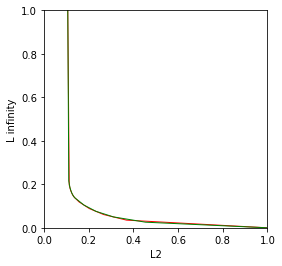

In [14]:
#plt.axhline(0, color='green')
#plt.axvline(0, color='green')
plt.figure(figsize=(4,4))
plt.plot(a, b, '-r', linewidth=1)
plt.plot(avg_list_loss_adversary1,avg_list_loss_adversary2, '-g', linewidth=1)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel('L2')
plt.ylabel('L infinity')
plt.savefig('L2_L_infinity_Cifar_paper_800_weights.png')

plt.show()

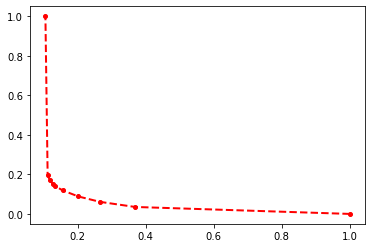

In [61]:
plt.plot(a, b, 'ro--', linewidth=2, markersize=4)

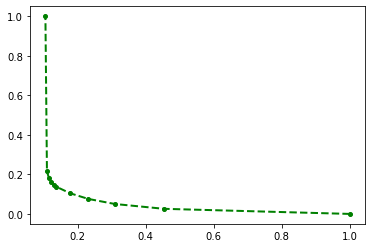

In [62]:
plt.plot(avg_list_loss_adversary1,avg_list_loss_adversary2, 'go--', linewidth=2, markersize=4)